# Credit Card Fraud Analysis

### [1] Sumary and introduction of the study  

The problem of fraudulent credit card transaction taking place is a bigger problem than most people realise it to be. The problem is not only based on the amount of money being stolen in the transactions, but more importantly the increase in the frequency or volumne of these type of transactions taking place on a daily basis. The increase in volume of these type of transactions taking place means it is very important for credit card companies to be able to identify and develop methods to decrease the number of clients that are being charged for transactions that they did not incur.

_What does this data represent?_<br>
The following data is credit card transaction data made by European credit card holders for a random day in September 2013. Out of the original 284,807 transactions that exist in teh dataset, a subset of 90,000 of these transactions is used in this study. 

_Purpose of analysis?_<br>
The purpose of this study is to create models that can be used to predict wehther a transaction is fraudulent or not using the relationships that exist within the data. To achieve this we will use regression and decison tree modelling, and then artificial neural networks.

_Data source:_<br>
The dataset source can be found at: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


## [2] Data study and general imports

In [85]:
# import 
import Analysis_repo
from Analysis_repo import sourceCode
from Analysis_repo import notebook_import_library as importLibrary


# Get the data form the Source code file
try:
    creditCard_p1_data = sourceCode.sendCreditCardData_part1() # credit card data part 1
    #print(creditCard_p1_data.columns) # print ouut the columns
    creditCard_p2_data = sourceCode.sendCreditCardData_part2() # credit card data part 2
    #print(creditCard_p2_data.columns) # print out the columns
    creditcardData_analysis = importLibrary.pd.concat([importLibrary.pd.DataFrame(creditCard_p1_data), importLibrary.pd.DataFrame(creditCard_p2_data)]) # append the two parts of the credit card data together
    creditcardData_analysis.reset_index(drop=True, inplace=True)
except Exception as e:
    print("An exception occurred:", e)

In [62]:
# 1. Dimension of the datset
print("Rows: ", creditcardData_analysis.shape[0], "Cols: ", creditcardData_analysis.shape[1], "\n")

# 2. Data types to be observed in the dataset i.e., Dataset info
#print("Data type info:",creditcardData_analysis.info())
 

# 3. Checking for missing data in the dataset
missingDataCount =  creditcardData_analysis.isna().sum()
#print("Missing data per column:", missingDataCount)


# 4. Distribution of Class type per transaction
class_dist = creditcardData_analysis['Class'].value_counts().head(3)
print("Frequency of transaction by Class:", class_dist, "\n") 

# 5. Snippet of the data 
print("First 2 rows data snippet:")
creditcardData_analysis.head(2)

Rows:  90000 Cols:  31 

Frequency of transaction by Class: Class
0    89789
1      211
Name: count, dtype: int64 

First 2 rows data snippet:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


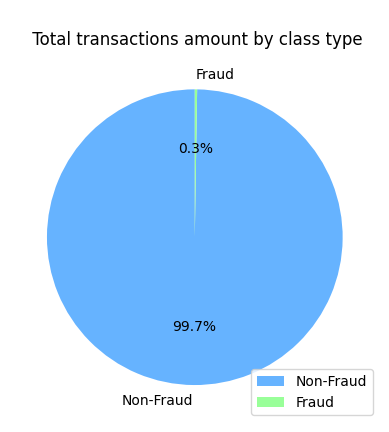

In [5]:
# 1 - Get transaction amount data grouped by Class
grouped_data = creditcardData_analysis.groupby('Class')['Amount'].sum().reset_index()

# 2 - Set labels
labels = grouped_data.Class.replace(1, 'Fraud').replace(0, "Non-Fraud")
sizes =  grouped_data.Amount 

# 3 -  Plot all the transactions data
importLibrary.plt.title("\n Total transactions amount by class type")
importLibrary.plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99'])

# 4 - Plot extra
importLibrary.plt.legend(labels, loc='lower right')
importLibrary.plt.show()

- _Plot observation_ : From this Pie Chart we can observe in terms of Euro amounts, Fraudulent transactions account for less than 0.5% of the amount in transactions.

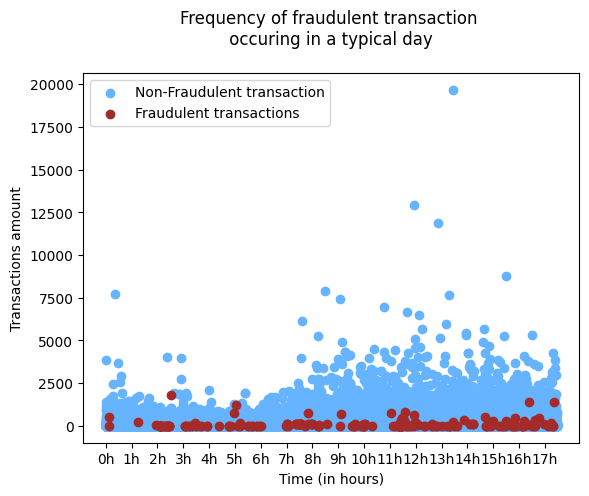

In [65]:
# 1 - Get time and amount of non-fraudulent data and plot the data on a scatter plot
Amount = creditcardData_analysis["Amount"][creditcardData_analysis["Class"]== 0]
time_ = creditcardData_analysis["Time"][creditcardData_analysis["Class"]== 0]

importLibrary.plt.scatter(time_, Amount, color='#66b3ff', label='Non-Fraudulent transaction')


# 2 - Get time and amount of fraudulent data
time_of_fraud = creditcardData_analysis['Time'][creditcardData_analysis["Class"]== 1]
y_additional = creditcardData_analysis['Amount'][creditcardData_analysis["Class"]== 1]


# 3 -  Plot all the transactions data
importLibrary.plt.title('Frequency of fraudulent transaction \n occuring in a typical day \n')
importLibrary.plt.scatter(time_of_fraud, y_additional, color='brown', label='Fraudulent transactions')
importLibrary.plt.xticks(importLibrary.np.arange(0, max(time_) + 1, 3600), [f'{int(t/3600)}h' for t in importLibrary.np.arange(0, max(time_) + 1, 3600)])
importLibrary.plt.xlabel('Time (in hours)')
importLibrary.plt.ylabel('Transactions amount')


# 4 - Plot extra
importLibrary.plt.legend()
importLibrary.plt.show()

- _Plot observation_ : From this scatter plot the problem we are trying to address is how to accurately determine which transactions are fradulent and which are not on a consistent basis, as teh amount of fraud money is a probelm together with its volume during the day.

## [3] Regression Modelling

In this section we will make use of a regression to predict the class type of credit card transaction. The 'Class' column in the _creditcardData-analyis_ will be used as the independent variable and all the other the columns will used as the dependent variables in out study.

For this study we want to determine, hoiw effective are a are certain input as vaiable indicators in determing teh class type of the transaction. We will use to model outputs to test effectiveness of the model by focusing on its key metrics such as the $R^2$, Mean Squared Error, Mean Absolute Error to mention few.


In [90]:
# Forming a linear regression model for our study

#independent and dependent variables
Variable_inputs_X = creditcardData_analysis.drop("Class", axis=1) # Drop the class column
Output_domain_Y = creditcardData_analysis['Class'] # Get the data

# set seeds and generte random variables
i = importLibrary.np.random.choice(Output_domain_Y.index, size = len(Output_domain_Y), replace= False)
importLibrary.np.random.seed(19184914) # set seed

# Get interger vlaue of 70% the training set interger set size of
train_set_size = int(len(creditcardData_analysis) * 0.7)  

# train test split for the data points:
x_train = Variable_inputs_X.loc[i][:train_set_size]
y_train = Output_domain_Y.loc[i][:train_set_size]
   
x_test = Variable_inputs_X.loc[i][train_set_size:]
y_test = Output_domain_Y.loc[i][train_set_size:]

# Form a linear regression model
full_model = importLibrary.LinearRegression().fit(x_train, y_train) #form regression model.
full_model.coef_, full_model.intercept_

# print basic statistics:
print("Model Coefficients: \n", full_model.coef_)
print("\n Model Intercept:", round(full_model.intercept_, 5))


Model Coefficients: 
 [ 1.96676646e-08 -1.06244621e-03  2.66195928e-03 -4.42037203e-03
  3.63603302e-03 -6.27408220e-04 -1.70084651e-03 -5.12150427e-03
 -5.22820911e-05 -3.58474669e-03 -7.79426203e-03  5.76480081e-03
 -1.02343118e-02 -6.58873776e-04 -1.33029242e-02 -2.74130505e-04
 -7.53370887e-03 -1.22380995e-02 -4.12519232e-03  1.29537065e-03
 -7.92249159e-04  1.36587855e-03  1.36651438e-03  1.64138401e-05
 -3.54357935e-04  5.43480431e-04  2.11321880e-03 -1.22884641e-04
 -3.10561212e-04  9.86177760e-06]

 Model Intercept: 0.00096


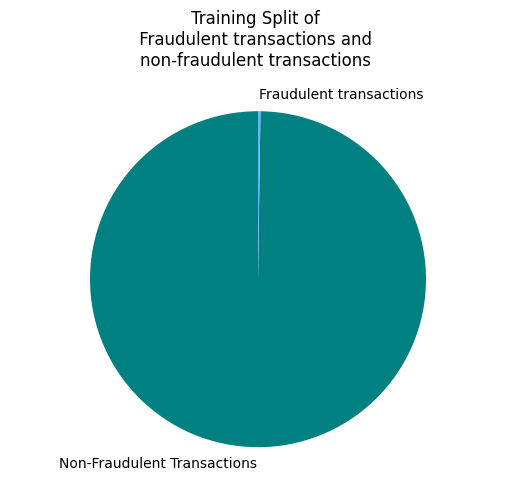

In [91]:
# Plots for the the training-testing data split
# 1 - Pie chart - Comparing the weight of fraud and non fraudulent transactions 
zero_count = (creditcardData_analysis['Class'] == 0).sum()
num_count = (creditcardData_analysis['Class'] == 1).sum()
fraud_class_labels = ['Non-Fraudulent Transactions', 'Fraudulent transactions']
transactions_sizes_weight = [zero_count, num_count]  # Transaction type sizes

# Pie Chart creation
importLibrary.plt.pie(transactions_sizes_weight, labels=fraud_class_labels, colors=['teal', '#66b3ff'], startangle=90)
importLibrary.plt.axis('equal')
importLibrary.plt.title('Training Split of \n Fraudulent transactions and  \nnon-fraudulent transactions \n')

# Show the pie chart
importLibrary.plt.show()

#### [3.1] Testing the effectiveness of the model

To test the model that has been trained, we compute statistics to help us analyze the effectiveness of the model that has been created.
We form a regression model then trian it accoridngly. 

Areas of interest in our study:
1. $R^2$ value
2. Mean Square Error
3. Mean Absolute Error
4. $R^2$ range of comparison values
5. If $R_0^2 = 0.5$ is used; Comment on the effectiveness if the model.
6. Recommendations on the model and how can we improve the model by removing which variables?
7. Which explanatory variable does have the minimum and maximum linear relationships with the Class variable?
8. Improve the model by adding data to the new model. Has the new model been improved?
9. Import the _creditCardData-prediction_ and use the model in q8 to predict the transaction Class of the new _10000_ transactions. 
    * From the prediction data how many transactions are considered Fraudulent? Compare this value with the actual fraudulent transactions in the dataset. 
10. Conclusion on findings

In [92]:
# 1. R^2 value

# Forming OLS regression
me_model = importLibrary.sm.OLS(y_train, x_train).fit()  

# Obtain the coefficient of determination and interpet it. Evaluate the model
y_pred = full_model.predict(x_test)
base_model_rsquared = importLibrary.r2_score(y_test, y_pred)
print("R-Squared: " , round(base_model_rsquared, 4), "\n")

# Get the train and test R2 values
r2_range = importLibrary.r2_score(y_train, me_model.predict(x_train)), importLibrary.r2_score(y_test, me_model.predict(x_test))
r2_train_test  = r2_range

# Findings:
print("Meaning of R-Squared: ")
percentage = round((base_model_rsquared * 100),2)
print("Using the model,", percentage,"% of the variance of Class value can be explained by the explanatory variables used in the model.")
print("The training vs. testing ranges are: ",round(r2_train_test[0], 4), round(r2_train_test[1], 4), "respectively.")
print("The predicted values of C ")


R-Squared:  0.6157 

Meaning of R-Squared: 
Using the model, 61.57 % of the variance of Class value can be explained by the explanatory variables used in the model.
The training vs. testing ranges are:  0.5087 0.6157 respectively.
The predicted values of C 


In [93]:
#2. Mean Square Error

base_MSE_train = round(importLibrary.mean_squared_error(y_train, full_model.predict(x_train)),5)
base_MSE_test = round(importLibrary.mean_squared_error(y_test, full_model.predict(x_test)),5)

print("Train:", base_MSE_train, "Test:", base_MSE_test)


print(" Mean Square Error output:")
print("Train:", importLibrary.mean_squared_error(y_train, full_model.predict(x_train)), "Test:", importLibrary.mean_squared_error(y_test, full_model.predict(x_test)))
print(
    " Explaination.. is .....", '\n',
    "", '\n'  
)

Train: 0.00123 Test: 0.00075
 Mean Square Error output:
Train: 0.001228937875710592 Test: 0.0007527814263624292
 Explaination.. is ..... 
  



In [94]:
#3. Mean Absolute Error

base_MAE_train = round(importLibrary.mean_absolute_error(y_train, full_model.predict(x_train)),5)
base_MAE_test = round(importLibrary.mean_absolute_error(y_test, full_model.predict(x_test)),5)

print("Mean Absolute Error output:")
print("Train",base_MAE_train,"Test:",base_MAE_test)
print(
    " Explaination.. is .....", '\n',
    "", '\n'  
)

# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Class notes >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Mean Absolute Error output:
Train 0.00489 Test: 0.00426
 Explaination.. is ..... 
  



In [95]:
#4. R^2 range of comparison values
base_R2_train = round(importLibrary.r2_score(y_train, full_model.predict(x_train)),5)
base_R2_test = round(importLibrary.r2_score(y_test, full_model.predict(x_test)),5)

print("R^2 value output:")
print("Train", base_R2_train,"Test", base_R2_test)
print(
    "The training and testing values of r2 are very close to one another.", '\n',
    "This illustrates to us that the model is either accurately working well or accurately not working well with the data.", '\n'  
    "", '\n'  
    "", '\n'  
)
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Class notes >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

R^2 value output:
Train 0.50876 Test 0.61574
The training and testing values of r2 are very close to one another. 
 This illustrates to us that the model is either accurately working well or accurately not working well with the data. 
 
 



In [96]:
#5. If R0^2 = 0.5 is used a barometer for models; Comment on the effectiveness of the model.
r0_value = 0.5

print(
    "Using the value of R0=", r0_value,"and the value of R2 =",base_R2_test,"as the vlaues of comparision, we can conclude that:" '\n',
    "Our model is acceptable for use since our tested R2 is greater than the R0^2 value given", '\n',
    "The model is also a good fit since the values of R2_train and R2_test are",base_R2_train,"and",base_R2_train,"respectively", '\n',
    "The narrow range between the values illustrate this to us.", '\n'  
)

Using the value of R0= 0.5 and the value of R2 = 0.61574 as the vlaues of comparision, we can conclude that:
 Our model is acceptable for use since our tested R2 is greater than the R0^2 value given 
 The model is also a good fit since the values of R2_train and R2_test are 0.50876 and 0.50876 respectively 
 The narrow range between the values illustrate this to us. 



In [97]:
# 6. Recommendations on the model and how can we improve the model?
print(
    "From question 5 we can deduce that the model is a good fit, however this does not mean the model cannot be improved.", '\n',
    "Possible ways of improving the model include:", '\n',
    "1. Adding more transaction data to the model.", '\n',
    "2. Removing variables that have a low linear relationship with the 'Class' variable and finding the 'right mix' of variables for our regression analysis.", '\n'
)


From question 5 we can deduce that the model is a good fit, however this does not mean the model cannot be improved. 
 Possible ways of improving the model include: 
 1. Adding more transaction data to the model. 
 2. Removing variables that have a low linear relationship with the 'Class' variable and finding the 'right mix' of variables for our regression analysis. 



In [98]:
# 7. Which explanatory variable does have the highest and min linear relationships with the Class variable?

# get the correlation series of each explanaotry variable with MedHouseVal
explanatory_correlation_series = creditcardData_analysis.corr()['Class'].drop('Class')
max_cor = explanatory_correlation_series.idxmax()
min_cor = explanatory_correlation_series.idxmin()

# Output
print("Variables having the min and the max linear relationship with `Class` are", min_cor, "and",max_cor,"respectively.")

Variables having the min and the max linear relationship with `Class` are V17 and V11 respectively.


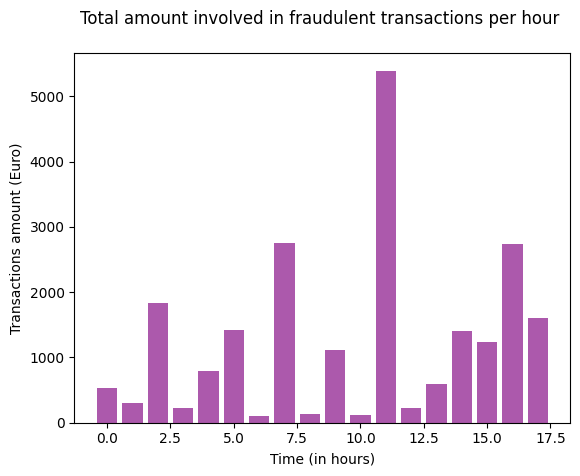

In [99]:
#  Plot of amount in inolved in fraudulent transaction per hour

# 1 - Create Hour column
hour_list = []
    
for time in creditcardData_analysis['Time']:
    hour_conversion = int(time/3600) 
    hour_list.append(hour_conversion)

creditcardData_analysis['Hour'] = hour_list


# 2 - Group the data by hour
grouped_data = creditcardData_analysis.groupby(['Hour', 'Class'])['Amount'].sum().reset_index()
fraud_amt_hour_data = grouped_data[['Hour', 'Amount']][grouped_data["Class"]== 1]
fraud_amt_df = importLibrary.pd.DataFrame(fraud_amt_hour_data)


# 3 - Plot data
importLibrary.plt.title("Total amount involved in fraudulent transactions per hour \n")
importLibrary.plt.bar(fraud_amt_df['Hour'], fraud_amt_df['Amount'], color='purple', alpha=0.65)
importLibrary.plt.xlabel('Time (in hours)')
importLibrary.plt.ylabel('Transactions amount (Euro)')


# 4 - Plot extra
importLibrary.plt.show()

In [102]:
# 8. Improve the model by adding data to the new model. Has the new model been improved?

importLibrary.np.random.seed(191849142) # set seed

#independent and dependent variables
Variable_inputs_X = creditcardData_analysis.drop(["Class", "Hour"], axis=1)
Output_domain_Y = creditcardData_analysis['Class']

# add new data to the model; set seeds and generte random variables
# set seeds and generte random variables
boosted_i = importLibrary.np.random.choice(Output_domain_Y.index, size = len(Output_domain_Y), replace= False)

boosted_training_set_n = int(len(creditcardData_analysis) * 0.8)

boosted_x_train = Variable_inputs_X.loc[boosted_i][:boosted_training_set_n]
boosted_y_train = Output_domain_Y.loc[boosted_i][:boosted_training_set_n]
boosted_x_test = Variable_inputs_X.loc[boosted_i][boosted_training_set_n:]
boosted_y_test = Output_domain_Y.loc[boosted_i][boosted_training_set_n:]


# fit model with new data
boosted_model = importLibrary.LinearRegression().fit(boosted_x_train, boosted_y_train)

# Predict the R2, MAE, MSE values
booosted_y_pred = boosted_model.predict(boosted_x_test)
boosted_model_rsquared = round(importLibrary.r2_score(boosted_y_test, booosted_y_pred),5)

boosted_MAE_train = round(importLibrary.mean_absolute_error(y_train, full_model.predict(x_train)),5)
boosted_MAE_test = round(importLibrary.mean_absolute_error(y_test, full_model.predict(x_test)),5)

boosted_MSE_train = round(importLibrary.mean_squared_error(y_train, full_model.predict(x_train)),5)
boosted_MSE_test = round(importLibrary.mean_squared_error(y_test, full_model.predict(x_test)),5)


# Model comparision from me_model vs boosted_model
print("R-Squared comparison: ")
print("The value of RSquared between models changed from ", round(base_model_rsquared,5), "to", boosted_model_rsquared, "in the boosted model")
print("From the base model to the boosted model teh R2 value improved significantly from by",round(boosted_model_rsquared - base_model_rsquared, 4) ,"points", "\n")

print("MSE comaprison: ")
print("The test value of MSE  between models changed from", base_MSE_test ,"to", boosted_MSE_test, "in the boosted model")
print("As we can observe from the mean squared error of the model remained the same even when we added new data and boosted  the model \n")

print("MAE comparison: ")
print("The test value of MAE between models changed from", base_MAE_test, "to", boosted_MAE_test, "in the boosted model")
print("IN booth instances of the base and booosted model the mean absoluate error of the models remained the same")


R-Squared comparison: 
The value of RSquared between models changed from  0.61574 to 0.58359 in the boosted model
From the base model to the boosted model teh R2 value improved significantly from by -0.0321 points 

MSE comaprison: 
The test value of MSE  between models changed from 0.00075 to 0.00075 in the boosted model
As we can observe from the mean squared error of the model remained the same even when we added new data and boosted  the model 

MAE comparison: 
The test value of MAE between models changed from 0.00426 to 0.00426 in the boosted model
IN booth instances of the base and booosted model the mean absoluate error of the models remained the same


In [101]:
# 9. Import the creditCardData_prediction and use the model in q8 to predict the transaction Class of the new 10000 transactions. 

try:
    creditcardData_prediction_data = sourceCode.sendPredictionDataset()
except Exception as e:
    print("An exception occurred:", e)

    
mod_predict_data = creditcardData_prediction_data.drop("Class", axis=1)
mod_actual_class_data = creditcardData_prediction_data["Class"]

booosted_y_pred = boosted_model.predict(mod_predict_data)

predict_class_list = []

for value in booosted_y_pred:
    int_value = int(value)
    predict_class_list.append(int(value))


# 9.1 - From the prediction data how many transactions are considered Fraudulent?
pred_fraudent_transactions = len([value for value in predict_class_list if value == 1])
print("The model predicts that:", pred_fraudent_transactions, "fraudulent transactions in the dataset")

# 9.2 -  Compare this value with the actual Fraudulent transactions in the dataset.
actual_fraudent_transactions = len([value for value in mod_actual_class_data if value == 1])
print("The actual count of class data is:", actual_fraudent_transactions)


The model predicts that: 38 fraudulent transactions in the dataset
The actual count of class data is: 63


In [ ]:
# 10. Conclusion on findings
print(
    "", '\n',
    "", '\n',
    "", '\n',
    "", '\n'  
)


## [4] Decision Tree Modelling

In this section I made use a decison tree model to predict if a credit card. In previous model we created a model
using regression modelling, however as we see in our regression model conclusion the model is not accurate enough in predicting the degree of relationships that exist between the independent and dependent variables in our study.

Decison tree models are more effective in uncovering relationships in linear and complex relationships that exist between the independent and dependent variables in our study.Decision tree models also handle missing data better, more versatile for classification and regression purposes.

In the following cells we will implement a decision tree model and use the model to predict the degree of relationships between the independent and dependent variables in our study and test its effectiveness.

In [20]:
# Decision tree modellign section imports
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [21]:
# Decison Tree model implementation

# 1- Get Class col and independent and dependent variables
Variable_inputs_X = creditcardData_analysis.drop("Class", axis=1) # Drop the class column
Output_domain_Y = creditcardData_analysis['Class'] # Get the data


# set seeds and generte random variables
i = importLibrary.np.random.choice(Output_domain_Y.index, size = len(Output_domain_Y), replace= False)
importLibrary.np.random.seed(42) # set seed


# Get interger vlaue of 70% the training set interger set size of
train_set_size = int(len(creditcardData_analysis) * 0.7)  
#print(train_set_size)


# train test split for the data points:
x_train = Variable_inputs_X.loc[i][:train_set_size]
y_train = Output_domain_Y.loc[i][:train_set_size]
   
x_test = Variable_inputs_X.loc[i][train_set_size:]
y_test = Output_domain_Y.loc[i][train_set_size:]


# create a decison tree classifier
dt_clf = DecisionTreeClassifier()


# Train the the train split
dt_clf.fit(x_train, y_train)

# 9 - Predict
class_pred = dt_clf.predict(x_test)


# 10 - Model accuracy
accuracy = accuracy_score(y_test, class_pred)
confusion = importLibrary.confusion_matrix(y_test, class_pred)

print("Accuracy:", accuracy)
print(f'Confusion Matrix:\n{confusion}') # explain the meaning of confusion matrix


Accuracy: 0.9993333580237769
Confusion Matrix:
[[26927     8]
 [   10    56]]


- < Sentiment here >


In [22]:
# plot the decision tree model <Chnage  athe plot to a nice looking plot>


tree_rules = export_text(dt_clf, feature_names=list(Variable_inputs_X.columns))
print(tree_rules)


|--- V17 <= -3.07
|   |--- V26 <= -0.22
|   |   |--- V27 <= 1.18
|   |   |   |--- V14 <= -3.18
|   |   |   |   |--- V6 <= -3.54
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- V6 >  -3.54
|   |   |   |   |   |--- class: 1
|   |   |   |--- V14 >  -3.18
|   |   |   |   |--- V25 <= 0.02
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- V25 >  0.02
|   |   |   |   |   |--- class: 0
|   |   |--- V27 >  1.18
|   |   |   |--- V24 <= 0.11
|   |   |   |   |--- class: 0
|   |   |   |--- V24 >  0.11
|   |   |   |   |--- V19 <= 1.10
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- V19 >  1.10
|   |   |   |   |   |--- class: 1
|   |--- V26 >  -0.22
|   |   |--- V4 <= 1.36
|   |   |   |--- V23 <= 0.07
|   |   |   |   |--- class: 0
|   |   |   |--- V23 >  0.07
|   |   |   |   |--- class: 1
|   |   |--- V4 >  1.36
|   |   |   |--- V1 <= -31.41
|   |   |   |   |--- class: 0
|   |   |   |--- V1 >  -31.41
|   |   |   |   |--- V28 <= 0.91
|   |   |   |   |   |--- class: 1
|   |   |   |  

- < Sentiment here >


## [5] Neural networks section

<! Under construction>

In [1]:
# import tensorflow as tf

# # Load or generate your training data

# # get size of the datset

# # For this example, let's assume you have features (X_train) and labels (y_train).

# # Define the neural network architecture

# # Compile the model

# # Train the model


# # Evaluate the model on a test dataset
